In [197]:
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp
#import eprint

import matplotlib.pyplot as plt
import math

import utils
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import time

## Variables globales

In [198]:
#definición de las variables generales
n = 10000
deltat = 0.001
t = np.arange(0, int(n*deltat), deltat)

N_SIMS = 10
N_TRAYEC = 25

In [199]:
# definicion de parametros fisicos y aerondinamicos del cohete
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073


# Caso A: Planeador

In [200]:
def real_coefs_mat(lib):
    data = [np.ones((n, 4))]
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['gamma', 'x', 'h', 'v'])

    mat = np.zeros((data[0].shape[1], n_features))
    mat[1, list_names.index('v*cos(gamma)')] = 1
    mat[2, list_names.index('+v*sen(gamma)')] = 1

    return mat


In [201]:
x0 = [20, 200, 2000, 100]

t_sims = np.zeros(N_SIMS)
error_A = np.zeros(N_SIMS)

for i in range(N_SIMS):
    t_start = time.time()
    mod_class = utils.Model()
    mod_class.eval(utils.casoA, N_TRAYEC, t, [None], x0, adim=False, 
                mod=utils.Model_params(feature_list=['gamma', 'x', 'h', 'v'], lib=utils.custom_ecs_A()))
    _ = mod_class.error_trayec(t)
    t_sims[i] = time.time() - t_start

    error_A[i] = np.mean((real_coefs_mat(utils.custom_ecs_A())-mod_class.model_sindy.coefficients())**2)

times_A = t_sims.mean()
error_A = np.median(error_A)
mod_class.model_sindy.print(lhs=["gamma'", "x'", "h'", "v'"], precision=10)


gamma' = 0.0000000000
x' = 1.0000000000 v*cos(gamma)
h' = 1.0000000000 +v*sen(gamma)
v' = 0.0000000000


# Caso B: Vuelo rectilíneo y simétrico: T cte y V variable y grande

In [202]:
T0 = 12 # T/m
A = 0.5*1.225*cd0*S/m
B = k*9.81**2/(0.5*1.225*S/m)
print(f"Valor de los coeficientes: A={A}, C={T0}")

Valor de los coeficientes: A=0.0013505625, C=12


In [203]:
v0 = 5

t_sims = np.zeros(N_SIMS)
error_B = np.zeros(N_SIMS)
for i in range(N_SIMS):
    t_start = time.time()
    mod_class = utils.Model()
    mod_class.eval(utils.casoB, N_TRAYEC, t, [T0, A, B], v0, 
                    mod=utils.Model_params(feature_list=['v'], lib=utils.custom_ecs_B()))
    _ = mod_class.error_trayec(t)
    t_sims[i] = time.time() - t_start

    real_coefs = np.array([-A*mod_class.maxi, 0, T0/mod_class.maxi])
    #error_B[i] = np.mean(mod_class.error_coefs(real_coefs.T)**2, axis=1)
    error_B[i] = np.mean((real_coefs-mod_class.model_sindy.coefficients())**2)

times_B = t_sims.mean()
error_B = np.median(error_B)
mod_class.model_sindy.print(lhs=["v'"], precision=8)

<ipython-input-203-00f05b26038a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod_class.maxi, 0, T0/mod_class.maxi])
<ipython-input-203-00f05b26038a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod_class.maxi, 0, T0/mod_class.maxi])
<ipython-input-203-00f05b26038a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

v' = -0.13506476 v^2 + 0.12000826 1


<ipython-input-203-00f05b26038a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod_class.maxi, 0, T0/mod_class.maxi])


# Caso C-1: Vuelo rectilíneo y simétrico: T cte y V variable y pequeña

In [204]:
A = 0.5*1.225*cd0*S/m*10
B = k*9.81**2/(0.5*1.225*S/m)
# Este es el coeficiete C, en realidad es T/m
T0 = 7
print(f"Valor real de los coeficientes: A={A}, B={B}, C=T0={T0}")
n_c1 = 100000
deltat_c1 = 0.00001
t_c1 = np.arange(0, int(n_c1*deltat_c1), deltat_c1)

Valor real de los coeficientes: A=0.013505625, B=156.0513186172428, C=T0=7


In [205]:
def real_coefs_mat(real_coefs, lib):
    data = [np.ones((n, 1))]
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v'])

    mat = np.zeros((data[0].shape[1], n_features))
    mat[0, list_names.index('v^2')] = real_coefs[0]
    mat[0, list_names.index('1/v^2')] = real_coefs[1]
    mat[0, list_names.index('1')] = real_coefs[2]

    return mat


In [206]:
v0 = 5

t_sims = np.zeros(N_SIMS)
error_C1 = np.zeros(N_SIMS)

for i in range(N_SIMS):
    t_start = time.time()
    mod_class = utils.Model()
    mod_class.eval(utils.casoC1, N_TRAYEC, t_c1, [T0, A, B], v0,
                    mod=utils.Model_params(feature_list=['v'], lib=utils.custom_ecs_B()))
    _ = mod_class.error_trayec(t_c1)
    t_sims[i] = time.time() - t_start

    real_coefs = np.array([-A*mod_class.maxi, -B/mod_class.maxi**3, T0/mod_class.maxi])
    mat_real = real_coefs_mat(real_coefs, utils.custom_ecs_B())

    error_C1[i] = np.mean(mod_class.error_coefs(mat_real)**2)

times_C1 = t_sims.mean()
error_C1 = np.median(error_C1)
mod_class.model_sindy.print(lhs=["v'"], precision=4)

v' = -0.1190 v^2 + -0.2875 1/v^2 + 0.8664 1


In [207]:
mod_class.model_sindy.print(lhs=["v'"], precision=4)

v' = -0.1190 v^2 + -0.2875 1/v^2 + 0.8664 1


In [208]:
real_coefs = np.array([-A*mod_class.maxi, -B/mod_class.maxi**3, T0/mod_class.maxi])
real_coefs

array([[-0.11062987],
       [-0.28391891],
       [ 0.85455562]])

# Caso C-2: Vuelo rectilíneo y simétrico: T cte y V variable y pequeña

In [209]:
n_c2 = 100000
deltat_c2 = 0.0001
t_c2 = np.arange(0, int(n_c2*deltat_c2), deltat_c2)

In [210]:
def real_coefs_mat2(real_coefs, lib):
    data = [np.ones((n, 1))]
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v'])

    mat = np.zeros((data[0].shape[1], n_features))
    mat[0, list_names.index('v^2')] = -(real_coefs[0] + 3*real_coefs[1])
    mat[0, list_names.index('v')] = 8*real_coefs[1]
    mat[0, list_names.index('1')] = -6*real_coefs[1]+real_coefs[2]

    return mat



In [211]:
v0 = 5
# Calculo el tiempo para la aproximación de Taylor de orden 2
t_sims = np.zeros(N_SIMS)
error_C2_2 = np.zeros(N_SIMS)

for i in range(N_SIMS):
    t_start = time.time()
    mod_class = utils.Model()
    mod_class.eval(utils.casoC2, N_TRAYEC, t_c2, [T0, A, B], v0,
                    mod=utils.Model_params(feature_list=['v'], lib=ps.PolynomialLibrary(degree=2)))
    _ = mod_class.error_trayec(t_c2)
    t_sims[i] = time.time() - t_start

    real_coefs = np.array([A*mod_class.maxi, B/mod_class.maxi**3, T0/mod_class.maxi])
    error_C2_2[i] = np.mean((mod_class.model_sindy.coefficients()-real_coefs_mat2(real_coefs, 
                                                                ps.PolynomialLibrary(degree=2)))**2)

times_C2_2 = t_sims.mean()         
error_C2_2 = np.median(error_C2_2)

mod_class.model_sindy.print(lhs=["v'"], precision=4)   

v' = 0.6819 v + -0.6845 v^2


In [212]:
-(real_coefs[0] + 3*real_coefs[1]), 8*real_coefs[1],-6*real_coefs[1]+real_coefs[2]

(array([-0.34272938]), array([0.11387285]), array([0.22969819]))

In [213]:
real_coefs_mat2(real_coefs,ps.PolynomialLibrary(degree=2)), mod_class.model_sindy.coefficients()

(array([[ 0.22969819,  0.11387285, -0.34272938]]),
 array([[ 0.        ,  0.68190413, -0.68448602]]))

In [214]:
def real_coefs_mat3(real_coefs, lib):
    data = [np.ones((n, 1))]
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v'])

    mat = np.zeros((data[0].shape[1], n_features))
    mat[0, list_names.index('v^3')] = 4*real_coefs[1]
    mat[0, list_names.index('v^2')] = -(real_coefs[0] + 15*real_coefs[1])
    mat[0, list_names.index('v')] = 20*real_coefs[1]
    mat[0, list_names.index('1')] = -10*real_coefs[1]+real_coefs[2]

    return mat


In [215]:
v0 = 5
# Calculo el tiempo para la aproximación de Taylor de orden 3
t_sims = np.zeros(N_SIMS)
error_C2 = np.zeros(N_SIMS)

for i in range(N_SIMS):
    t_start = time.time()
    mod_class = utils.Model()
    mod_class.eval(utils.casoC2, N_TRAYEC, t_c2, [T0, A, B], v0,
                    mod=utils.Model_params(feature_list=['v'], lib=ps.PolynomialLibrary(degree=3)))
    _ = mod_class.error_trayec(t_c2)
    t_sims[i] = time.time() - t_start

    real_coefs = np.array([A*mod_class.maxi, B/mod_class.maxi**3, T0/mod_class.maxi])
    error_C2[i] = np.mean((mod_class.model_sindy.coefficients()-real_coefs_mat3(real_coefs, 
                                                                ps.PolynomialLibrary(degree=3)))**2)

times_C2 = t_sims.mean()    
error_C2 = np.median(error_C2)     
mod_class.model_sindy.print(lhs=["v'"], precision=4)          

v' = -0.1807 1 + 1.6556 v + -2.2542 v^2 + 0.7812 v^3


In [216]:
real_coefs

array([[0.30003504],
       [0.01423297],
       [0.31509444]])

In [217]:
4*real_coefs[1],-(real_coefs[0] + 15*real_coefs[1]), 20*real_coefs[1],-10*real_coefs[1]+real_coefs[2]

(array([0.05693188]),
 array([-0.5135296]),
 array([0.28465942]),
 array([0.17276474]))

In [218]:
real_coefs_mat3(real_coefs,ps.PolynomialLibrary(degree=3)), mod_class.model_sindy.coefficients()

(array([[ 0.17276474,  0.28465942, -0.5135296 ,  0.05693188]]),
 array([[-0.18069077,  1.6556076 , -2.25422943,  0.7812171 ]]))

In [219]:
error_C2

1.4787160426615555

# Caso D-1: Loop ideal V no cte y empuje cte

In [220]:
T0 = 12 # T/m

R = 70
# velocidad caracteristica
U = (2*9.81*m/(1.225*S))**0.5
Tc = U/9.81
A1 = 0.5*1.225*U*Tc*S/m
A2 = Tc*9.81/U
A3 = T0*Tc/(U)
A4 = Tc*U/(R)
A5 = cd0 + k*A4**2
A6 = 2*k*A4
A7 = 1
A8 = k
print(f"Valor de los coeficientes: A1={A1}, A2={A2}, A3={A3}, A4={A4}, U={U}, Tc={Tc}")
print(f"Valores que sindy debe obtener: A3={A3}, A4={A4}, A5={A5}, A6={A6}, A7={A7}, A8={A8}")

Valor de los coeficientes: A1=0.9999999999999999, A2=1.0, A3=1.2232415902140672, A4=0.3173280974197259, U=14.76174801634704, Tc=1.5047653431546422
Valores que sindy debe obtener: A3=1.2232415902140672, A4=0.3173280974197259, A5=0.037350889863077684, A6=0.04632990222327998, A7=1, A8=0.073


In [221]:
def initial_vars(lib=utils.custom_ecs_D1()):   
    data = [np.ones((n, 2)), np.ones((n, 2))]
    print(data[0].shape, data[0].reshape(-1, 1).shape)
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v', 'gamma'])
    print(list_names)
    return n_features, data, list_names

In [222]:
def real_coefs_mat(real_coefs):
    features, data, list_names = initial_vars()
    mat = np.zeros((data[0].shape[1], features))

    mat[0, list_names.index('1v')] = real_coefs[4]
    mat[0, list_names.index('v^2')] = real_coefs[0]
    mat[0, list_names.index('cos(gamma)^2/v^2')] = real_coefs[3]
    mat[0, list_names.index('cos(gamma)')] = real_coefs[2]
    mat[0, list_names.index('sin(gamma)')] = real_coefs[1]
    mat[1, list_names.index('v')] = real_coefs[5]

    return mat

In [223]:
def error_coefs(real_coefs, sim_coefs):
    sim_coefs[0, -2] = sim_coefs[0, -2] + sim_coefs[0, -1]
    sim_coefs[0, -1] = 0

    return np.mean((real_coefs -  sim_coefs)**2)

In [224]:
deltat_train = 0.0001
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
mod = utils.Model_params(deltat=deltat_train, lib=utils.custom_ecs_D1(), opt=1,
            feature_list=['v', 'gamma'])

t_sims = np.zeros(N_SIMS)
error_D1 = np.zeros(N_SIMS)

rel = (t[1]-t[0])/deltat_train
real_coefs = np.array([-A5*rel, -A7*rel, -A6*rel, -A8*rel, A3*rel, A4*rel])
mat_real_coefs = real_coefs_mat(real_coefs)


for i in range(N_SIMS):
    t_start = time.time()
    mod_class = utils.Model()
    mod_class.eval(utils.casoD1, N_TRAYEC, t, 
                                        [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod)
    _ = mod_class.error_trayec(t)
    t_sims[i] = time.time() - t_start

    error_D1[i] = error_coefs(mat_real_coefs, mod_class.model_sindy.coefficients())

times_D1 = t_sims.mean()    
error_D1 = np.median(error_D1)

mod_class.model_sindy.print(lhs=["v'", "gamma'"], precision=4)

(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
v' = -0.3743 v^2 + -10.0045 sin(gamma) + -0.4482 cos(gamma) + -4.5439 cos(gamma)^2/v^2 + 12.3431 1v
gamma' = 3.1751 v


# Caso D-2: Loop ideal V cte y empuje no cte

In [225]:
m = 100
W = m*9.81

V0 = 10
R = 100
# velocidad caracteristica
U = (2*9.81*m/(1.225*S))**0.5
Tc = U/9.81
A1 = 0.5*1.225*S*V0**2
A2 = A1*cd0
A3 = (k*m**2 * V0**4)/(A1*R**2)
A4 = k*W**2/A1
A5 = (2*k*W*m*V0**2)/(R*A1)
A6 = V0/R*10
A7 = A2 + A3
A8 = A4*V0/R
A9 = A5*V0/R
A10 = W*V0/R
print(f"Valor de los coeficientes: A4={A4}, A5={A5}, A6={A6}, A7={A7}, W={W}")
print(f"Coeficientes que sindy debe calcular: A6={A6}, A8={A8}, A9={A9}, A10={A10}")

Valor de los coeficientes: A4=78.02565930862141, A5=15.907371928363181, A6=1.0, A7=27.8220232889074, W=981.0
Coeficientes que sindy debe calcular: A6=1.0, A8=7.802565930862142, A9=1.590737192836318, A10=98.1


In [226]:
def initial_vars(lib):
    data = [np.ones((n, 2)), np.ones((n, 2))]
    print(data[0].shape, data[0].reshape(-1, 1).shape)
    lib = utils.custom_ecs_D2().fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['T', 'gamma'])
    print(list_names)

    return n_features, data, list_names

In [227]:
def real_coefs_mat(real_coefs):
    features, data, list_names = initial_vars(lib=utils.custom_ecs_D2())
    mat = np.zeros((data[0].shape[1], features))

    mat[0, list_names.index('sin(2*gamma)')] = real_coefs[0]
    mat[0, list_names.index('sin(gamma)')] = real_coefs[1]
    mat[0, list_names.index('cos(gamma)')] = real_coefs[2]
    mat[1, list_names.index('1gamma')] = real_coefs[3]

    return mat

In [228]:
x0 = [5, 5] 

t_sims = np.zeros(N_SIMS)
error_D2 = np.zeros(N_SIMS)
for i in range(N_SIMS):
    t_start = time.time()
    mod_class = utils.Model()
    mod_class.eval(utils.casoD2, N_TRAYEC, t, [A6, A8, A9, A10], x0, 
                                        adim=False, ders=True, 
                                        mod=utils.Model_params(feature_list=['T', 'gamma'], lib=utils.custom_ecs_D2()))
    _ = mod_class.error_trayec(t)
    t_sims[i] = time.time() - t_start

    real_coefs = np.array([-A8, -A9, A10, A6])
    mat_real_coefs = real_coefs_mat(real_coefs)

    error_D2[i] = np.mean(mod_class.error_coefs(mat_real_coefs)**2)
    
mod_class.model_sindy.print(lhs=["T'", "gamma'"], precision=4)
error_D2 = np.median(error_D2)
times_D2 = t_sims.mean()  

(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


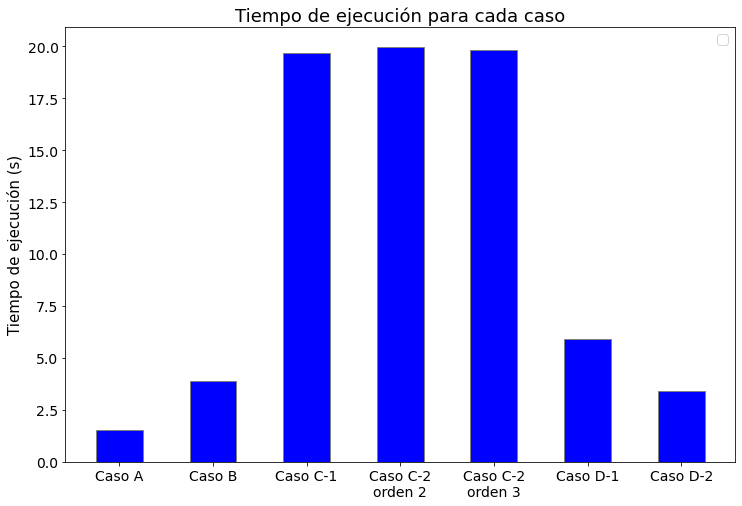

In [229]:
# representar tiempo de ejecucion de todos los casos
# set width of bar
barWidth = 0.5
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(7)
 
# Make the plot
plt.bar(br1, [times_A, times_B, times_C1, times_C2, times_C2_2, times_D1, times_D2], 
                color ='b', width = barWidth,
        edgecolor ='grey')
# Adding Xticks
#plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.title('Tiempo de ejecución para cada caso', fontsize=18)
plt.ylabel('Tiempo de ejecución (s)', fontsize = 15)
plt.xticks([r for r in range(7)],
         ['Caso A', 'Caso B', 'Caso C-1', 'Caso C-2\norden 2', 'Caso C-2\norden 3', 'Caso D-1', 'Caso D-2'], 
            fontsize=14)
plt.yticks(fontsize=14)
#plt.yscale('log')
plt.legend(fontsize = 14)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


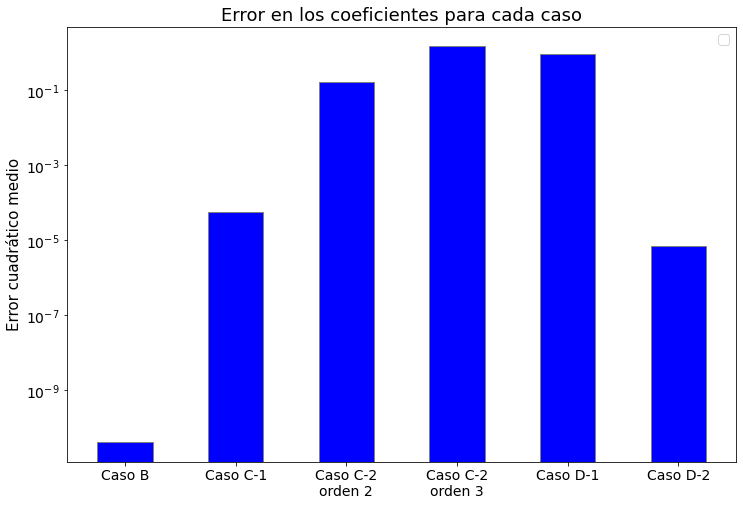

In [230]:
# representar error cuadratico medio de los coeficientes por caso
# set width of bar
barWidth = 0.5
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(6)
 
# Make the plot
plt.bar(br1, [error_B, error_C1, error_C2_2, error_C2, error_D1, error_D2], 
                color ='b', width = barWidth,
        edgecolor ='grey')
# Adding Xticks
#plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.title('Error en los coeficientes para cada caso', fontsize=18)
plt.ylabel('Error cuadrático medio', fontsize = 15)
plt.xticks([r for r in range(6)],
        ['Caso B', 'Caso C-1', 'Caso C-2\norden 2', 'Caso C-2\norden 3', 'Caso D-1', 'Caso D-2'], fontsize=14)
plt.yticks(fontsize=14)
#plt.yscale('log')
plt.yscale('log')
plt.legend(fontsize = 14)
plt.show()

In [231]:
error_A, error_B, error_C1, error_C2_2, error_C2, error_D1, error_D2

(2.2524043800467195e-25,
 4.2160013677975584e-11,
 5.696244442939797e-05,
 0.16375672127899604,
 1.4787160426615555,
 0.9412954067883923,
 6.844304072767409e-06)

In [232]:
#pseudocódigo de los pasos para cada caso
t = generar_vector_tiempos(n_puntos, paso_tiempo)
coefs = coeficientes_caso()

# condiciones iniciales para las trayectorias de train
cond_inic = condiciones_iniciales_aleatorias(variables)
# condiciones iniciales para la trayectoria de validacion
cond_inic_val = [cond1, cond2, ...]

# generar los datos según el caso
data_train, data_dot_train = generar_trayectoria(t, coefs, cond_inic, n_trayec)
data_val, data_dot_val = generar_trayectoria(t, coefs, cond_inic_val, 1)

# normalizar los datos si es necesario
if normalizar:
    data_train, data_dot_train = normalizar(data_train, data_dot_train)
    data_val, data_dot_val = normalizar(data_val, data_dot_val)

# añadir ruido AWGN
if ruido:
    data_train, data_dot_train = sumar_ruido(data, data_dot, pot_ruido, pot_ruido_dot)

# generar initial guess y restricciones en caso de que sea necesario, sino devuelve None
initial_guess, restric_lhs, restric_rhs = generar_restric(data.shape, n_restris, rhs)
lib = crear_libreria_funciones()
matriz_real_coefs = crear_mat_coefs(coefs, lib)

# crear el modelo de SINDy
model_sindy = ps.SINDy(
            optimizer=ps.sindy_opt(initial_guess=initial_guess, 
                    lhs=restric_lhs, rhs=restric_rhs), 
            feature_library=lib,                                           
            feature_names=['var1', 'var2'...], 
        )
# entrenar el modelo de SINDy       
model_sindy.fit(data_train, t=paso_tiempo, 
                multiple_trajectories=False, x_dot=data_dot_train)

x_sim = model_sindy.simulate(cond_inic_val, t)    
error_trayec = mean((x_sim-data_val)**2)
error_coefs = mean((model_sindy.coefficients()-matriz_real_coefs)**2)




SyntaxError: invalid syntax (<ipython-input-232-a8cd53c7c035>, line 33)